In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "50g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/01/25 15:39:50 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/01/25 15:39:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/25 15:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/25 15:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/25 15:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54720)
Traceback (most recent call last):
  File "/usr/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/

In [4]:
base_path = "/data/saturation/thesis_run_20250108/"

configs_pdf, configs_df, configs_dict = get_configs(
    base_path=base_path,
    spark=spark
)

25/01/25 15:39:53 WARN CacheManager: Asked to cache already cached data.


In [7]:
configs_pdf[configs_pdf.slope.between(-5.1, -4.9)].sort_values("slope")

,mrp,r_min,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio
14,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.5}",1.0,105.0,-5.0,125.0,1000.0,0.5,2.0
24,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.1}",1.0,21.0,-5.0,125.0,1000.0,0.1,2.0
28,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.3}",1.0,63.0,-5.0,125.0,1000.0,0.3,2.0
29,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.9}",1.0,189.0,-5.0,125.0,1000.0,0.9,2.0
42,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.7}",1.0,147.0,-5.0,125.0,1000.0,0.7,2.0
49,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.4}",1.0,84.0,-5.0,125.0,1000.0,0.4,2.0
50,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.8}",1.0,168.0,-5.0,125.0,1000.0,0.8,2.0
131,0.5,0.60,"{'name': None, 'ratio': 1000000.0}",1.5,8.0,-5.0,250.0,2000.0,-1.0,1000000.0
159,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.2}",1.0,42.0,-5.0,125.0,1000.0,0.2,2.0
185,0.5,0.55,"{'name': None, 'ratio': 2.0, 'exponent': 0.6}",1.0,126.0,-5.0,125.0,1000.0,0.6,2.0


## Example CSFD

In [26]:
simulation_id = 210
b_p = configs_dict[simulation_id]["slope"]
young_target_ntot = 5e2
older_target_ntot = 1e4
oldest_target_ntot = int(1e6)

study_region_size = configs_dict[simulation_id]["study_region_size"]
r_stat = configs_dict[simulation_id]["r_stat"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

sim_name = simulation_id
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

young_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    young_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)

older_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    older_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)

oldest_state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    oldest_target_ntot,
    study_region_size,
    study_region_padding,
    spark
)   

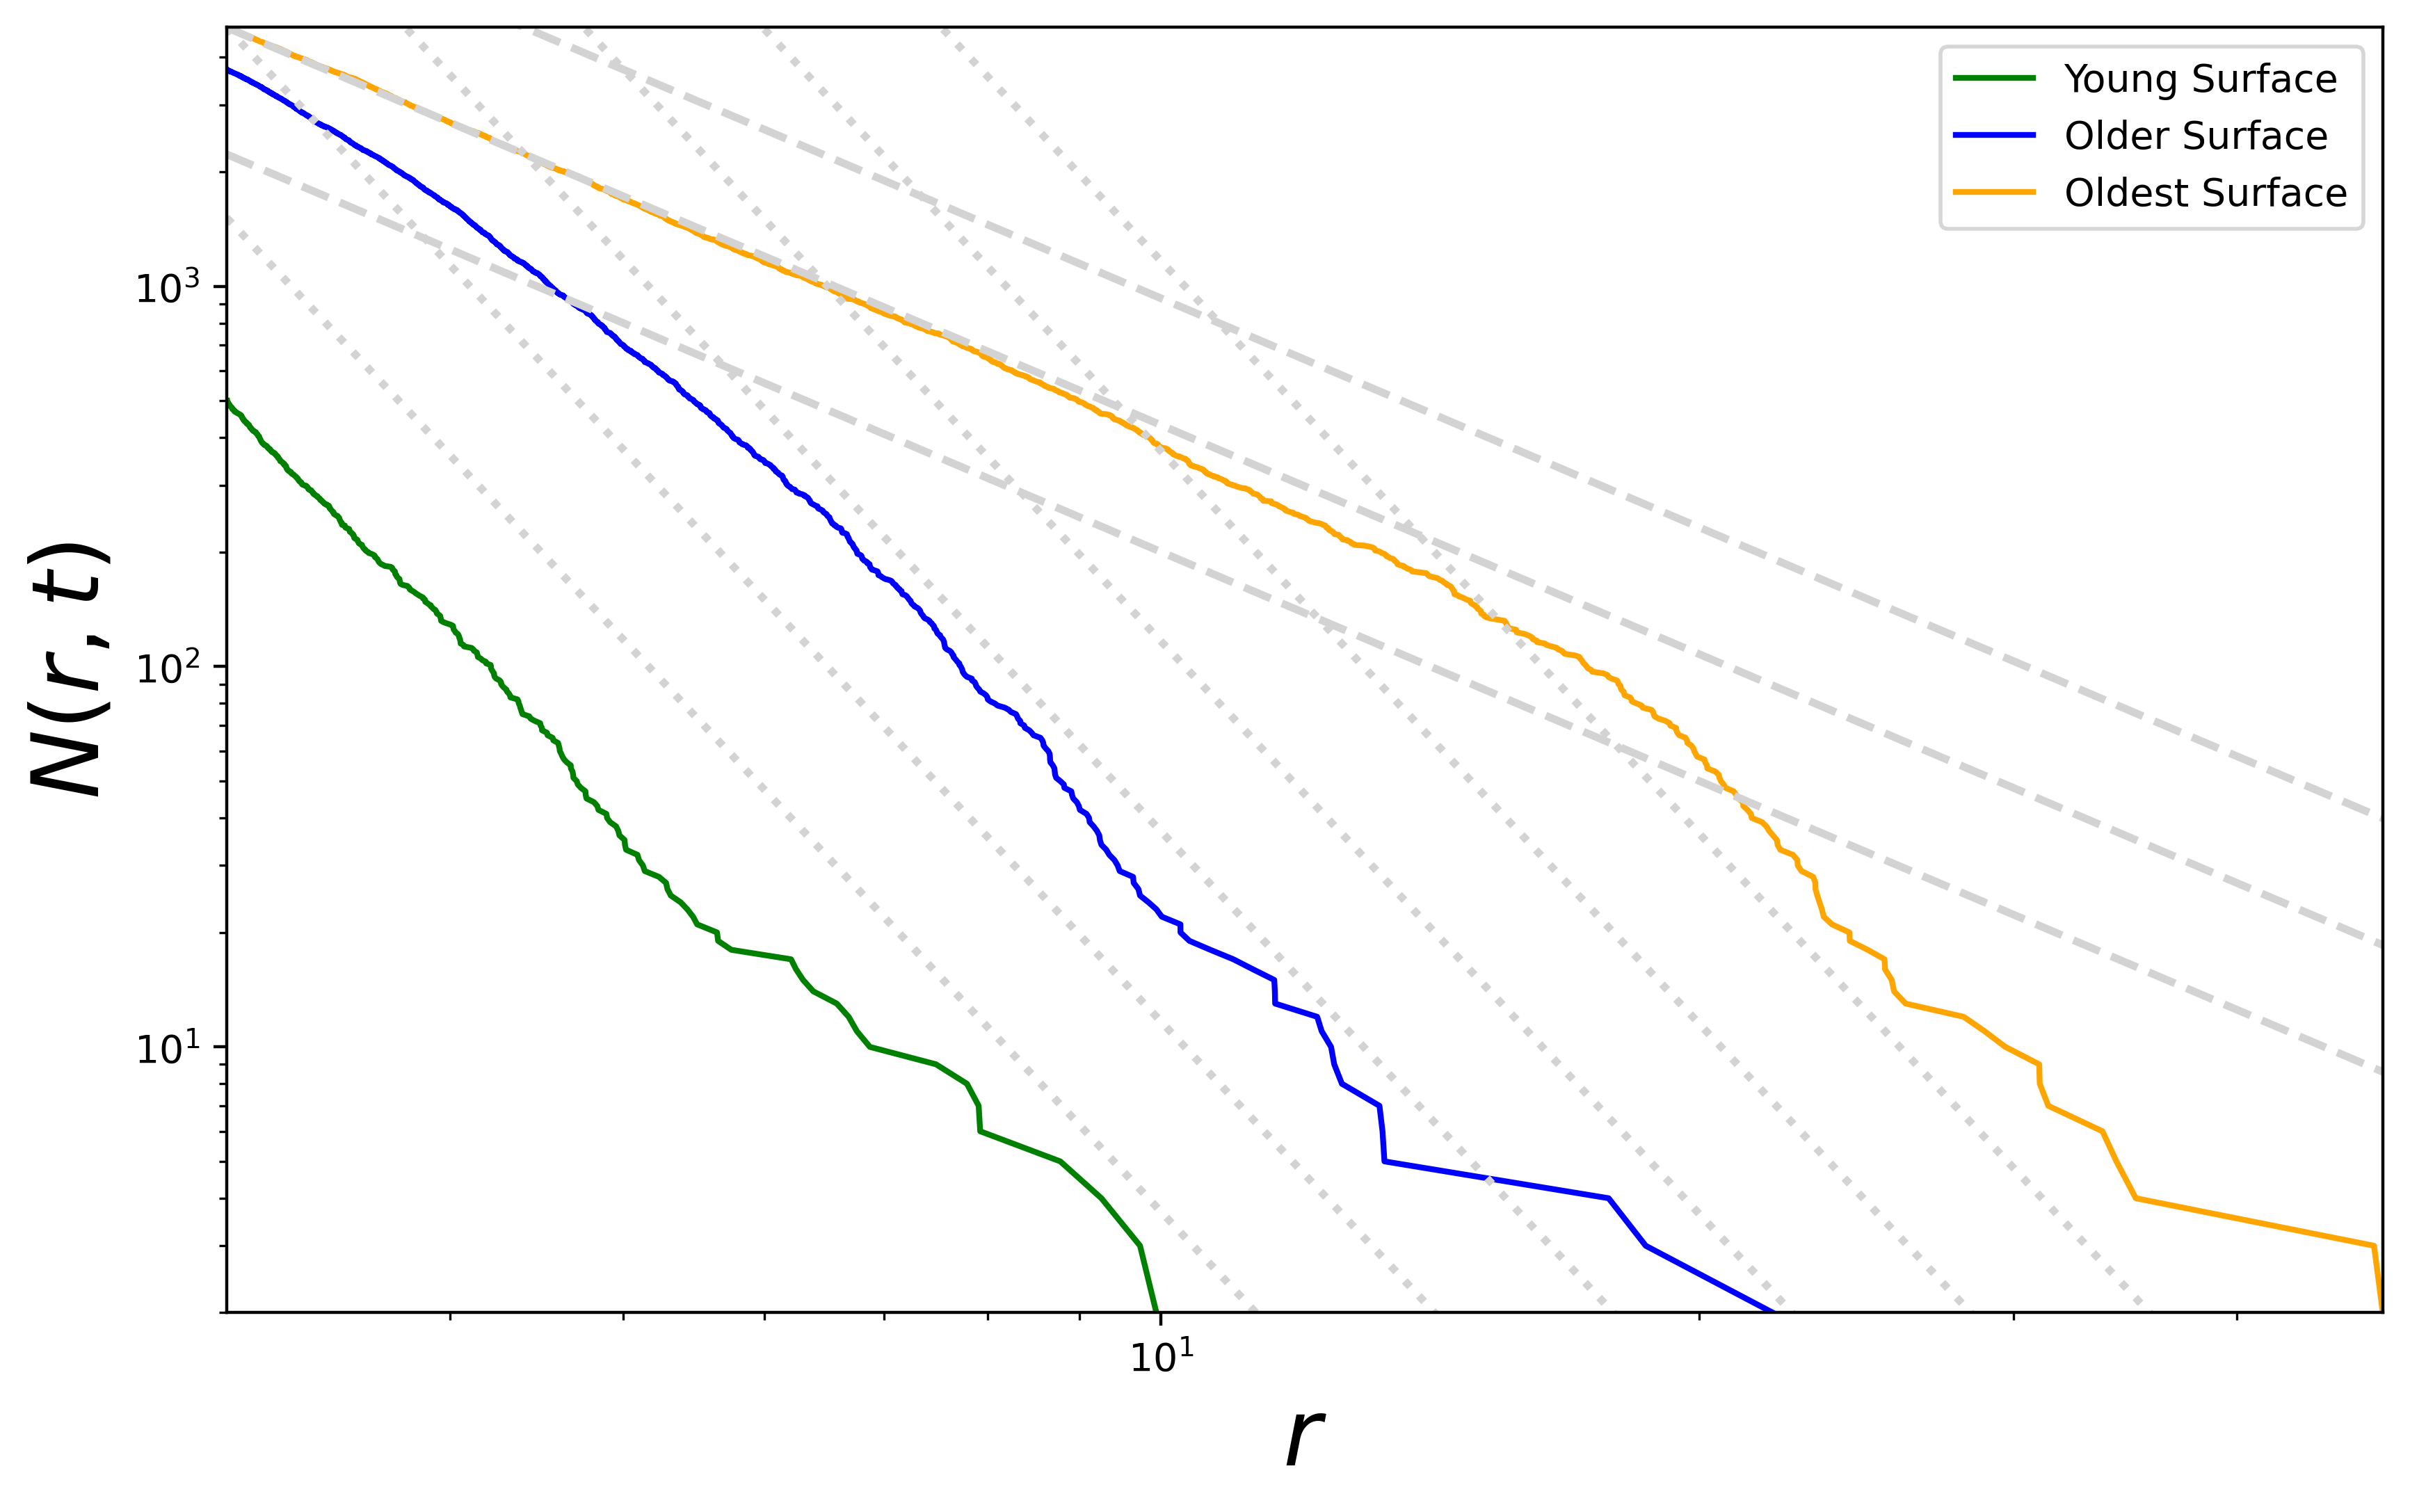

In [30]:
font_size = 24
saturation_ref_lines_indexes = range(-1, 2)
production_ref_lines = range(-1, 5)

young_radii = young_state.radius.sort_values()
older_radii = older_state.radius.sort_values()
oldest_radii = oldest_state.radius.sort_values()
nobs_ref = oldest_radii.count()
min_r_ref = oldest_radii.min()

fig = plt.figure(figsize=(10, 6), dpi=400)
ax = fig.add_subplot(111)

# Plot young state
observed_young_y = range(len(young_radii) + 1, 1, -1)
ax.plot(young_radii, observed_young_y, label="Young Surface", color="green")

# Plot older state
observed_older_y = range(len(older_radii) + 1, 1, -1)
ax.plot(older_radii, observed_older_y, label="Older Surface", color="blue")

# Plot old state
observed_oldest_y = range(len(oldest_radii) + 1, 1, -1)
ax.plot(oldest_radii, observed_oldest_y, label="Oldest Surface", color="orange")

# Add multiple reference lines for each slope
x_ref = np.logspace(np.log10(oldest_radii.min()), np.log10(oldest_radii.max()), 100)

saturation_ref_intercept = nobs_ref / min_r_ref ** -2
production_ref_intercept = nobs_ref / min_r_ref ** b_p

# Slopes and intercepts
reference_lines = {
    -2: {
        "intercepts": [10**(x / 3) * saturation_ref_intercept for x in saturation_ref_lines_indexes],
        "style": "dashed"
    },
    b_p: {
        "intercepts": [10**(x / 2) * production_ref_intercept for x in production_ref_lines],
        "style": "dotted"
    }
}

for b_ref, params in reference_lines.items():
    for intercept in params["intercepts"]:
        y_ref = intercept * x_ref**b_ref
        ax.plot(x_ref, y_ref,ls=params["style"], color="lightgray", lw="2")

# Set limits based on observed data
ax.set_xlim(oldest_radii.min(), oldest_radii.max())
ax.set_ylim(min(observed_oldest_y), max(observed_oldest_y))

# Labels and scaling
ax.set_xlabel("$r$", fontsize=font_size)
ax.set_ylabel("$N(r, t)$", fontsize=font_size)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

plt.savefig("figures/example_csfds.png", bbox_inches="tight")

plt.show()